# Adversarial examples with RAND + FGSM

### Imports

In [1]:
%matplotlib inline

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras import backend as K
from keras import metrics, applications
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


### Utils functions

In [2]:
CLASSES = [
    'Arc de Triomphe', 'Big Ben', 'Casa Loma', 'Castel Santangelo', 'Charlottenburg Palace', 
    'Colosseum', 'Dresden Frauenkirche', 'Eiffel Tower', 'Independence Hall',
    'Leaning Tower of Pisa', 'Milan Cathedral', 'Notre Dame Cathedral', 'Pantheon',
    'Reichstag', 'Sacre Coeur Basilica', 'Savior on Blood Church', 'St Basil Cathedral',
    'St Louis Cathedral', 'St Paul Cathedral', 'Statue of Liberty', 'Stephansdom',
    'Taj Mahal', 'Trevi Foutain', 'Tyn Church', 'Westminster Abbey'
]

def decode_predictions(predictions):
    return CLASSES[predictions.argmax()], predictions.max()

### Loading the model

In [3]:
img_width, img_height = 150, 150
n_classes = 25
K.set_learning_phase(1)

In [4]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_classes, activation='softmax'))

top_model.load_weights('../models/bottleneck.h5')

model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))

model.load_weights('../models/finetuning_full.h5')

### Example generation

In [33]:
epsilon = 0.07
alpha = 0.005

preprocess = lambda x: ((x / 255) - 0.5) * 2
deprocess = lambda x: (x / 2 + 0.5) * 255

def load_image(image_path):
    original_image = Image.open(image_path).resize((img_width, img_height))
    original_array = np.expand_dims(np.array(original_image), 0)

    return original_array

def get_gradient_signs(model, array):
    target_idx = model.predict(array).argmax()
    target = to_categorical(target_idx, n_classes)
    target_variable = K.variable(target)
    loss = metrics.categorical_crossentropy(model.output, target_variable)
    gradients = K.gradients(loss, model.input)
    get_grad_values = K.function([model.input], gradients)
    grad_values = get_grad_values([array])[0]
    grad_signs = np.sign(grad_values)
    
    return grad_signs

def perturbate_image(array, random_perturbation, gradient_perturbation):
    modified_array = array + random_perturbation + gradient_perturbation
    deprocess_array = np.clip(deprocess(modified_array), 0., 255.).astype(np.uint8)
    
    return deprocess_array

def generate_adversarial_example(pertubation_model, array):
    random_noise = np.random.normal(0, 1, original_array.shape)
    random_perturbation = alpha * random_noise
    gradient_signs = get_gradient_signs(pertubation_model, array)
    gradient_perturbation = gradient_signs * (epsilon - alpha)
    modified_image = perturbate_image(array, random_perturbation, gradient_perturbation)
    
    return modified_image, random_perturbation + gradient_perturbation

def generate_title(model, array):
    prediction = model.predict(array)
    category, proba = decode_predictions(prediction[0])
    
    return "'%s' %.1f%% confidence" % (category, proba * 100)

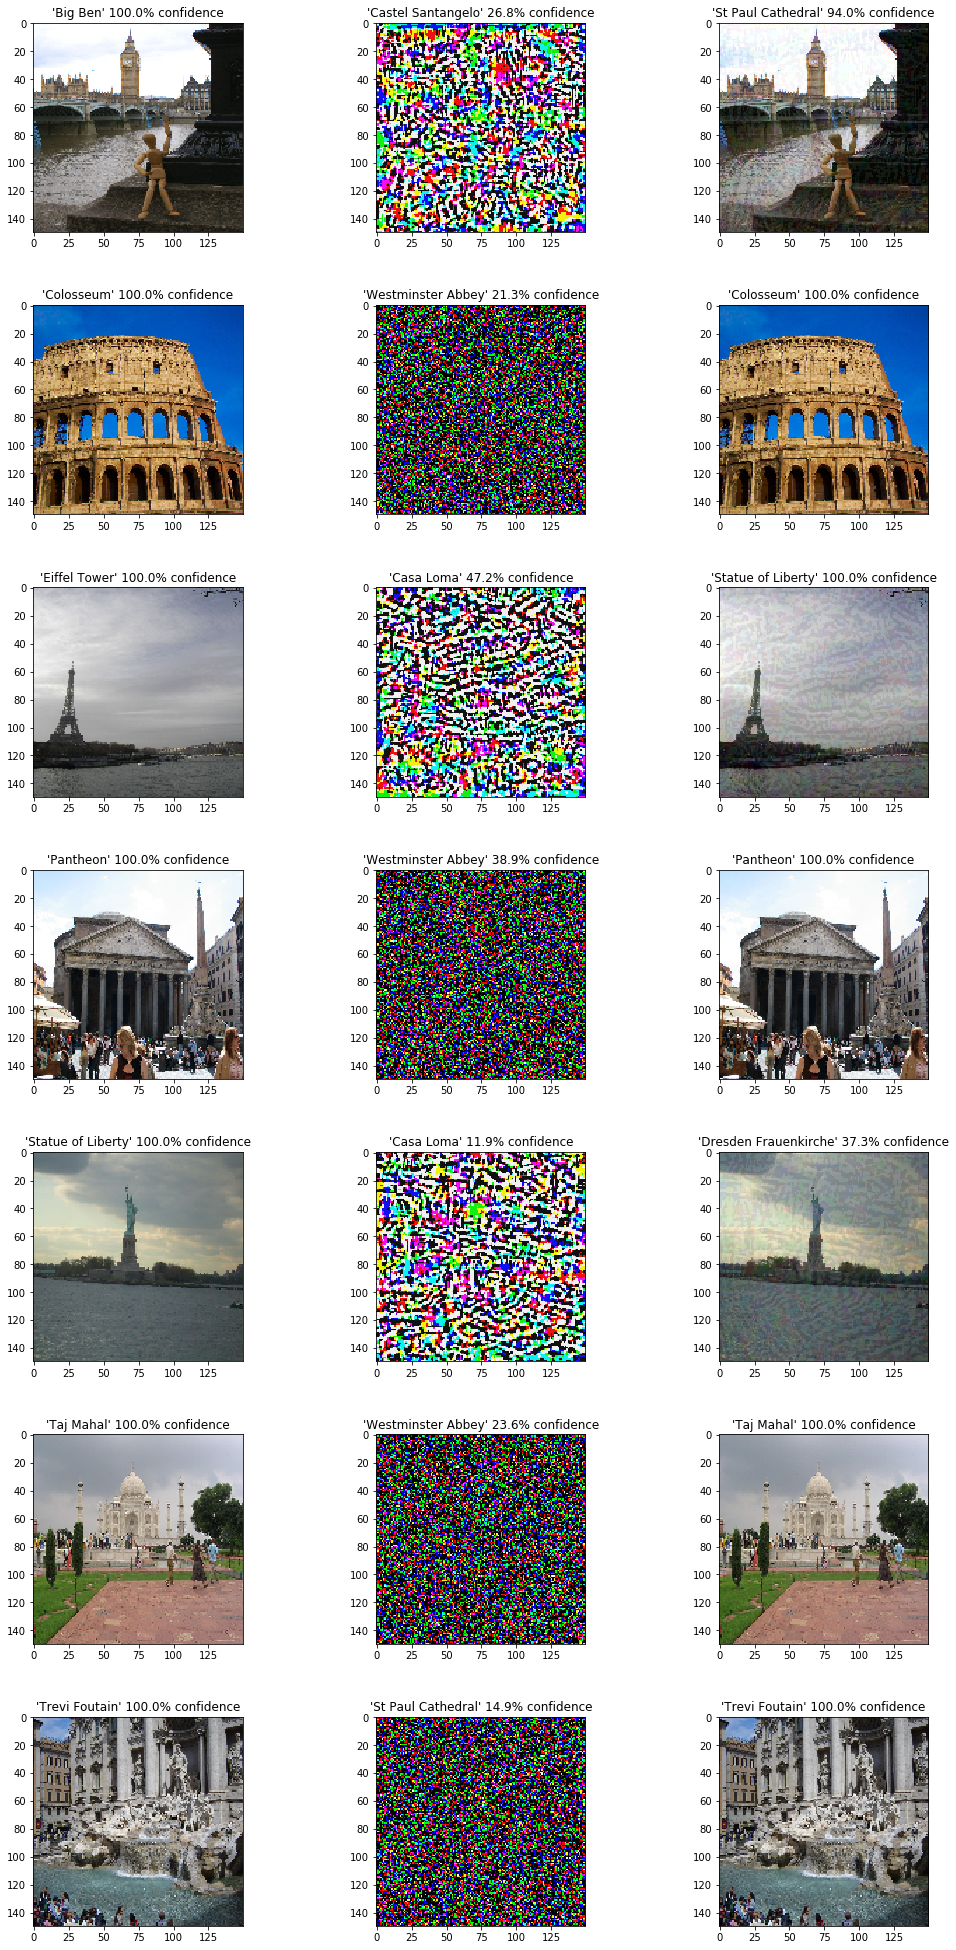

In [34]:
filenames = [
    '../data/validation/big_ben/138928302.jpg',
    '../data/validation/colosseum/183024981.jpg',
    '../data/validation/eiffel_tower/409963620.jpg',
    '../data/validation/pantheon/22907656.jpg',
    '../data/validation/statue_of_liberty/16932915.jpg',
    '../data/validation/taj_mahal/203697703.jpg',
    '../data/validation/trevi_fountain/404397212.jpg'    
]

n_lines = len(filenames)

plt.figure(figsize = (15, 4 * n_lines))

for line, filename in enumerate(filenames):
    if filename == '.DS_Store':
        continue
    
    original_array = load_image(filename)
    preprocessed_array = preprocess(original_array)
    modified_image, perturbation = generate_adversarial_example(model, preprocessed_array)
    preprocessed_modified_image = preprocess(modified_image)
    
    plt.subplot(n_lines, 3, 3 * line + 1)
    plt.imshow(original_array[0])
    plt.title(generate_title(model, preprocessed_array))
    plt.subplot(n_lines, 3, 3 * line + 2)
    plt.imshow(perturbation[0])
    plt.title(generate_title(model, perturbation))
    plt.subplot(n_lines, 3, 3 * line + 3)
    plt.imshow(modified_image[0])
    plt.title(generate_title(model, preprocessed_modified_image))

plt.tight_layout(pad = 4)